In [232]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [298]:
def load_operator_data(dataset_path='dataset'):
    IMG_SIZE = (28, 28)
    CLASSES = ['add', 'sub', 'mul', 'div']
    data = []
    labels = []
    
    for label, category in enumerate(CLASSES):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            print(f"Warning: Directory {category_path} not found!")
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # retain RGB channels
                img = img.resize(IMG_SIZE)
                img_array = np.array(img)
                # flatten image to 1D array
                data.append(img_array.flatten())
                labels.append(label)
                
    data = np.array(data)
    labels = np.array(labels)
    return data, labels, CLASSES

def load_mnist_from_csv(train_path, test_path):
    train_data = pd.read_csv(train_path)
    if train_data.isna().any().any():
        train_data = train_data.fillna(0)
    
    X_train = train_data.iloc[:, 1:].values.astype(np.float32) / 255.0
    y_train = train_data.iloc[:, 0].values.astype(int)
    
    test_data = pd.read_csv(test_path)
    if test_data.isna().any().any():
        test_data = test_data.fillna(0)
    
    X_test = test_data.iloc[:, 1:].values.astype(np.float32) / 255.0
    y_test = test_data.iloc[:, 0].values.astype(int)
    
    return X_train, y_train, X_test, y_test

In [300]:
def visualize_digits(images, labels, num_samples=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(str(labels[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [260]:
def train_evaluate_rfc(X_train, y_train, X_test, y_test):
    """
    Trains a Random Forest Classifier
    """
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = clf.predict(X_test)
    predict_time = time.time() - start_time
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Model training time: {train_time:.2f} seconds")
    print(f"Prediction time: {predict_time:.2f} seconds")
    print(f"Accuracy: {acc * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf, y_pred

--- Operator Model Training ---
Model training time: 0.72 seconds
Prediction time: 0.01 seconds
Accuracy: 94.90%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       122
           1       0.95      0.98      0.97       132
           2       0.94      0.97      0.96       122
           3       0.93      0.93      0.93       114

    accuracy                           0.95       490
   macro avg       0.95      0.95      0.95       490
weighted avg       0.95      0.95      0.95       490



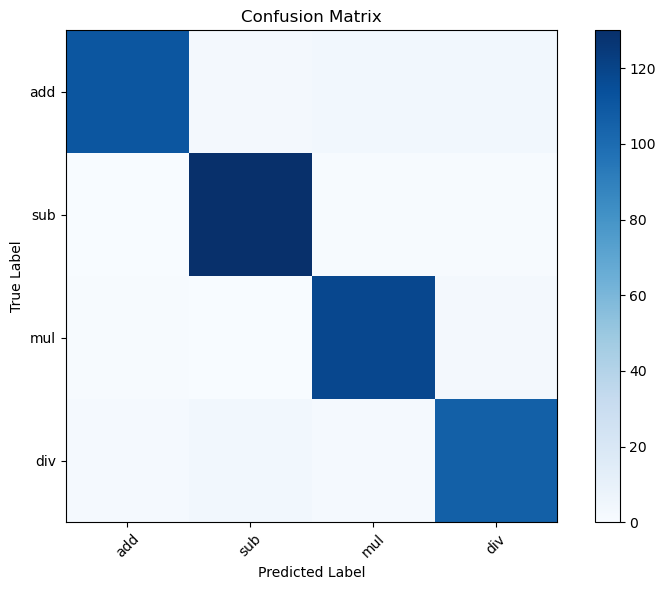

--- MNIST Digit Model Training ---
Displaying sample digits from MNIST:


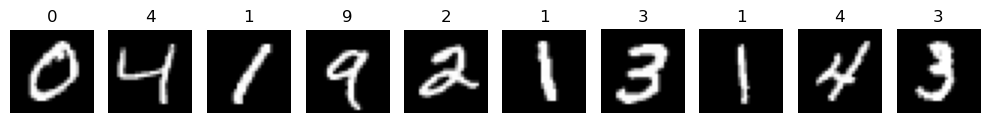

Model training time: 26.43 seconds
Prediction time: 0.16 seconds
Accuracy: 96.87%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1027
           8       0.96      0.95      0.95       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999



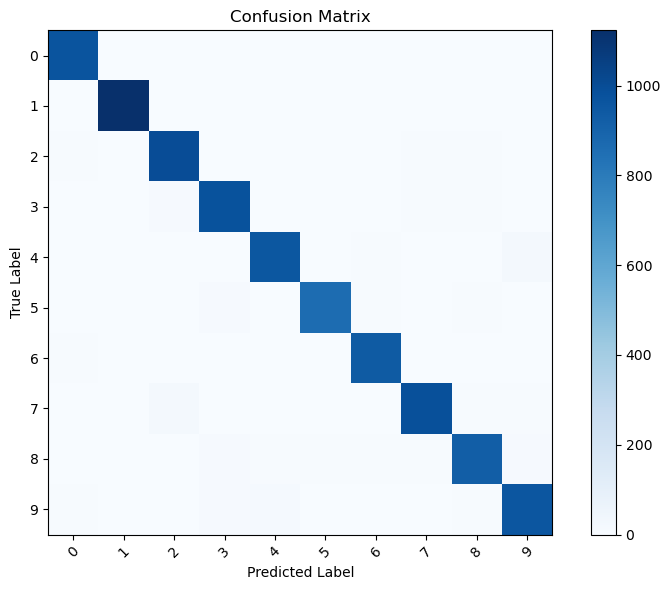

['digit_model.joblib']

In [302]:
print("--- Operator Model Training ---")
op_data, op_labels, op_classes = load_operator_data(dataset_path='dataset')
X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(
    op_data, op_labels, test_size=0.2, random_state=42)

operator_clf, op_y_pred = train_evaluate_rfc(X_train_op, y_train_op, X_test_op, y_test_op)
plot_confusion_matrix(y_test_op, op_y_pred, classes=op_classes)

# Save operator model to avoid retraining every time
joblib.dump(operator_clf, 'operator_model.joblib')



print("--- MNIST Digit Model Training ---")
train_path = "mnist_train.csv"
test_path = "mnist_test.csv"

X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist = load_mnist_from_csv(train_path, test_path)

print("Displaying sample digits from MNIST:")
visualize_digits(X_train_mnist, y_train_mnist)

digit_clf, mnist_y_pred = train_evaluate_rfc(X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist)
plot_confusion_matrix(y_test_mnist, mnist_y_pred, classes=[str(i) for i in range(10)])

# Save MNIST model
joblib.dump(digit_clf, 'digit_model.joblib')

In [335]:
def merge_boxes(boxes, gap_threshold=500, vertical_threshold=15):
    """
    Merge bounding boxes
    """
    merged = []
    boxes = sorted(boxes, key=lambda b: b[0])
    i = 0
    while i < len(boxes):
        current_x, current_y, current_w, current_h = boxes[i]
        current_box = [current_x, current_y, current_w, current_h]
        while i < len(boxes) - 1:
            next_box = boxes[i + 1]
            next_x, next_y, next_w, next_h = next_box

            gap = next_x - (current_box[0] + current_box[2])
            
            current_center = current_box[1] + current_box[3] / 2
            next_center = next_y + next_h / 2
            vertical_diff = abs(current_center - next_center)
            
            if gap < gap_threshold and vertical_diff < vertical_threshold:
                new_x = min(current_box[0], next_x)
                new_y = min(current_box[1], next_y)
                new_w = max(current_box[0] + current_box[2], next_x + next_w) - new_x
                new_h = max(current_box[1] + current_box[3], next_y + next_h) - new_y
                current_box = [new_x, new_y, new_w, new_h]
                i += 1
            else:
                break
        merged.append(tuple(current_box))
        i += 1
    return merged

In [337]:
def segment_expression(image_path):
    """
    Segments a full expression image into individual characters using OpenCV
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} cannot be loaded.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h < 100:  # ignore very small contours
            continue
        boxes.append((x, y, w, h))
    
    merged_boxes = merge_boxes(boxes, gap_threshold=15, vertical_threshold=500)
    merged_boxes.sort(key=lambda b: b[0])
    
    segments = []
    for box in merged_boxes:
        x, y, w, h = box
        roi_color = image[y:y+h, x:x+w]
        segments.append((box, roi_color))
        
    return segments

In [339]:
def preprocess_segment_for_digit(roi_color):
    roi_gray = cv2.cvtColor(roi_color, cv2.COLOR_RGB2GRAY)

    _, roi_bin = cv2.threshold(roi_gray, 127, 255, cv2.THRESH_BINARY_INV)

    coords = cv2.findNonZero(roi_bin)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        roi_cropped = roi_bin[y:y+h, x:x+w]
    else:
        roi_cropped = roi_bin

    # add padding to replicate MNIST formatting
    h, w = roi_cropped.shape
    side = max(h, w)
    pad_top = (side - h) // 2
    pad_bottom = side - h - pad_top
    pad_left = (side - w) // 2
    pad_right = side - w - pad_left
    roi_padded = cv2.copyMakeBorder(
        roi_cropped,
        top=pad_top + 40, bottom=pad_bottom + 40,
        left=pad_left + 40, right=pad_right + 40,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

    roi_resized = cv2.resize(roi_padded, (28, 28), interpolation=cv2.INTER_AREA)

    roi_scaled = roi_resized.astype(np.float32) / 255.0
    roi_flat = roi_scaled.flatten()
    return roi_flat

def preprocess_segment_for_operator(roi_color):
    h, w, _ = roi_color.shape
    if h > w:
        pad = (h - w) // 2
        roi_padded = cv2.copyMakeBorder(roi_color, 0, 0, pad, pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    elif w > h:
        pad = (w - h) // 2
        roi_padded = cv2.copyMakeBorder(roi_color, pad, pad, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        roi_padded = roi_color

    roi_resized = cv2.resize(roi_padded, (28, 28))
    roi_flat = roi_resized.flatten()
    return roi_flat


In [321]:
def compare_mnist_and_segmented(mnist_X, mnist_y, segmented_rois, num_samples=5):
    mnist_indices = random.sample(range(len(mnist_X)), num_samples)
    plt.figure(figsize=(10, 4))
    print("--- MNIST Samples ---")
    for i, idx in enumerate(mnist_indices):
        img = mnist_X[idx].reshape(28, 28)
        label = mnist_y[idx]
        aspect = 1.0  # Already square
        white_px = np.sum(img > 0.1)
        print(f"MNIST #{i} — Label: {label}, Shape: {img.shape}, White pixels: {white_px}, Range: [{img.min():.2f}, {img.max():.2f}]")
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"MNIST: {label}")
        plt.axis("off")

    print("--- Segmented Samples ---")
    for i in range(num_samples):
        if i >= len(segmented_rois):
            break
        roi = segmented_rois[i]
        processed = preprocess_segment_for_digit(roi).reshape(28, 28)
        h, w = roi.shape[:2]
        aspect = w / h
        white_px = np.sum(processed > 0.1)
        print(f"ROI #{i} — Original: {roi.shape}, Preprocessed: {processed.shape}, Aspect: {aspect:.2f}, White pixels: {white_px}, Range: [{processed.min():.2f}, {processed.max():.2f}]")
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(processed, cmap="gray")
        plt.title(f"Segmented #{i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def classify_segment(idx, roi_color, digit_model, operator_model):
    digit_input = preprocess_segment_for_digit(roi_color)
    operator_input = preprocess_segment_for_operator(roi_color)

    digit_probs = digit_model.predict_proba([digit_input])[0]
    operator_probs = operator_model.predict_proba([operator_input])[0]
    max_digit_prob = np.max(digit_probs)
    max_operator_prob = np.max(operator_probs)

    h, w, _ = roi_color.shape
    aspect_ratio = w / h if h != 0 else 1

    if idx % 2 == 0:
        prediction = digit_model.predict([digit_input])[0]
        symbol = str(prediction)
        clf_used = 'digit'
    else:
        prediction = operator_model.predict([operator_input])[0]
        # assumed order: [add, sub, mul, div]
        op_mapping = {0: '+', 1: '-', 2: '*', 3: '/'}
        symbol = op_mapping.get(prediction, '?')
        clf_used = 'operator'
    
    return symbol, clf_used

In [313]:
def process_expression(image_path, digit_model, operator_model, debug=False):
    segments = segment_expression(image_path)
    rois = [roi for box, roi in segments]

    compare_mnist_and_segmented(X_train_mnist, y_train_mnist, rois, num_samples=5)
    expression = ""
    
    if debug:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for box, _ in segments:
            x, y, w, h = box
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        plt.imshow(image)
        plt.title("Merged Segmentation Results")
        plt.axis('off')
        plt.show()

    idx = 0
    for box, roi in segments:
        symbol, clf_used = classify_segment(idx, roi, digit_model, operator_model)
        idx += 1
        print(f"Box {box}: Classified as {symbol} using {clf_used} model")
        expression += symbol
    return expression

In [315]:
def safe_eval(expression):
    try:
        result = eval(expression)
    except Exception as e:
        raise ValueError(f"Error evaluating expression: {e}")
    return result


Processing image: expressions/2s2.png
--- MNIST Samples ---
MNIST #0 — Label: 9, Shape: (28, 28), White pixels: 192, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 136, Range: [0.00, 1.00]
MNIST #2 — Label: 5, Shape: (28, 28), White pixels: 159, Range: [0.00, 1.00]
MNIST #3 — Label: 4, Shape: (28, 28), White pixels: 164, Range: [0.00, 1.00]
MNIST #4 — Label: 0, Shape: (28, 28), White pixels: 246, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (165, 239, 3), Preprocessed: (28, 28), Aspect: 1.45, White pixels: 109, Range: [0.00, 1.00]
ROI #1 — Original: (34, 230, 3), Preprocessed: (28, 28), Aspect: 6.76, White pixels: 60, Range: [0.00, 1.00]
ROI #2 — Original: (223, 191, 3), Preprocessed: (28, 28), Aspect: 0.86, White pixels: 123, Range: [0.00, 1.00]


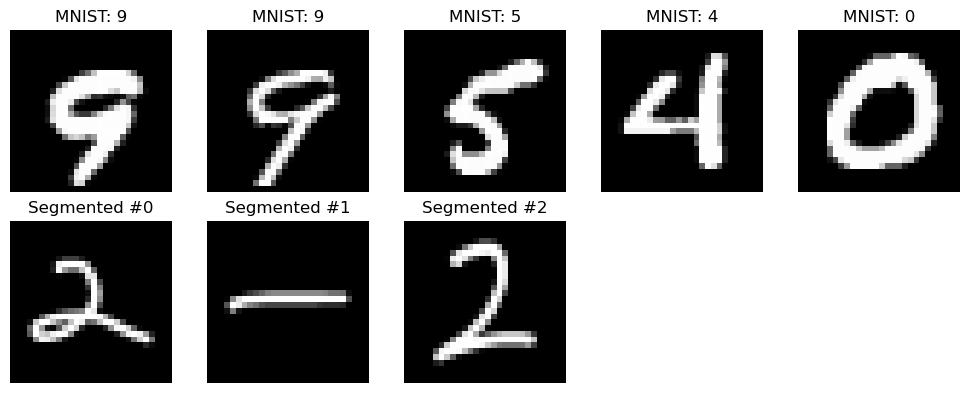

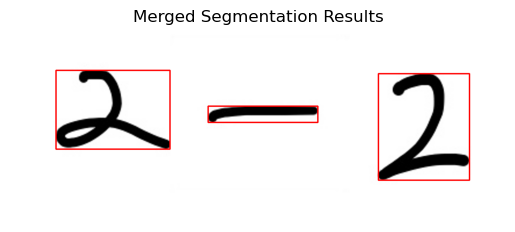

Box (96, 84, 239, 165): Classified as 2 using digit model
Box (415, 159, 230, 34): Classified as / using operator model
Box (772, 91, 191, 223): Classified as 2 using digit model
Reconstructed Expression: 2/2
Evaluation Result: 1.0

Processing image: expressions/1p2.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 133, Range: [0.00, 1.00]
MNIST #1 — Label: 9, Shape: (28, 28), White pixels: 93, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 90, Range: [0.00, 1.00]
MNIST #3 — Label: 0, Shape: (28, 28), White pixels: 176, Range: [0.00, 1.00]
MNIST #4 — Label: 3, Shape: (28, 28), White pixels: 181, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (221, 37, 3), Preprocessed: (28, 28), Aspect: 0.17, White pixels: 60, Range: [0.00, 1.00]
ROI #1 — Original: (236, 216, 3), Preprocessed: (28, 28), Aspect: 0.92, White pixels: 92, Range: [0.00, 1.00]
ROI #2 — Original: (208, 117, 3), Preprocessed: (28, 28), Aspect: 0.56, White p

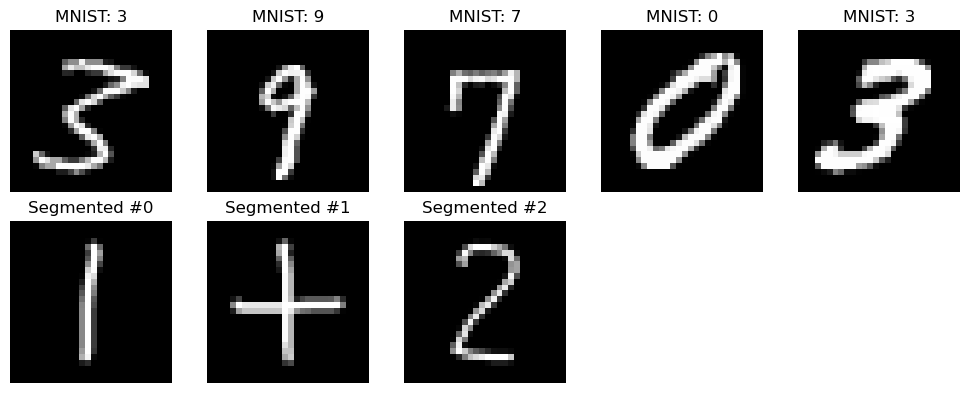

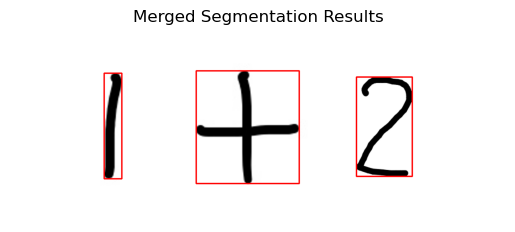

Box (197, 90, 37, 221): Classified as 1 using digit model
Box (390, 85, 216, 236): Classified as + using operator model
Box (726, 98, 117, 208): Classified as 2 using digit model
Reconstructed Expression: 1+2
Evaluation Result: 3

Processing image: expressions/8m0.png
--- MNIST Samples ---
MNIST #0 — Label: 8, Shape: (28, 28), White pixels: 142, Range: [0.00, 1.00]
MNIST #1 — Label: 7, Shape: (28, 28), White pixels: 106, Range: [0.00, 1.00]
MNIST #2 — Label: 7, Shape: (28, 28), White pixels: 92, Range: [0.00, 1.00]
MNIST #3 — Label: 3, Shape: (28, 28), White pixels: 126, Range: [0.00, 1.00]
MNIST #4 — Label: 8, Shape: (28, 28), White pixels: 119, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (258, 149, 3), Preprocessed: (28, 28), Aspect: 0.58, White pixels: 146, Range: [0.00, 1.00]
ROI #1 — Original: (221, 185, 3), Preprocessed: (28, 28), Aspect: 0.84, White pixels: 123, Range: [0.00, 1.00]
ROI #2 — Original: (165, 169, 3), Preprocessed: (28, 28), Aspect: 1.02, White

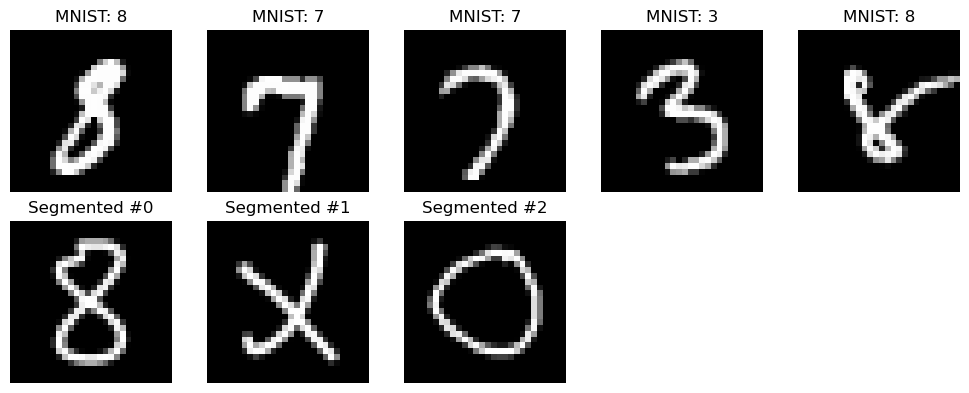

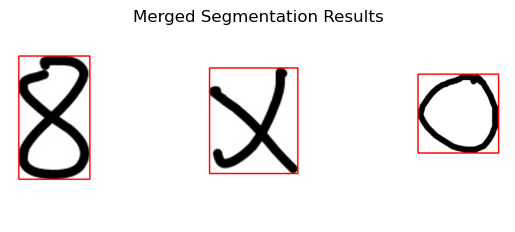

Box (18, 54, 149, 258): Classified as 8 using digit model
Box (418, 79, 185, 221): Classified as * using operator model
Box (855, 92, 169, 165): Classified as 0 using digit model
Reconstructed Expression: 8*0
Evaluation Result: 0

Processing image: expressions/3p3.png
--- MNIST Samples ---
MNIST #0 — Label: 5, Shape: (28, 28), White pixels: 146, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 135, Range: [0.00, 1.00]
MNIST #2 — Label: 8, Shape: (28, 28), White pixels: 171, Range: [0.00, 1.00]
MNIST #3 — Label: 1, Shape: (28, 28), White pixels: 57, Range: [0.00, 1.00]
MNIST #4 — Label: 2, Shape: (28, 28), White pixels: 186, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (192, 118, 3), Preprocessed: (28, 28), Aspect: 0.61, White pixels: 115, Range: [0.00, 1.00]
ROI #1 — Original: (243, 279, 3), Preprocessed: (28, 28), Aspect: 1.15, White pixels: 89, Range: [0.00, 1.00]
ROI #2 — Original: (167, 183, 3), Preprocessed: (28, 28), Aspect: 1.10, White 

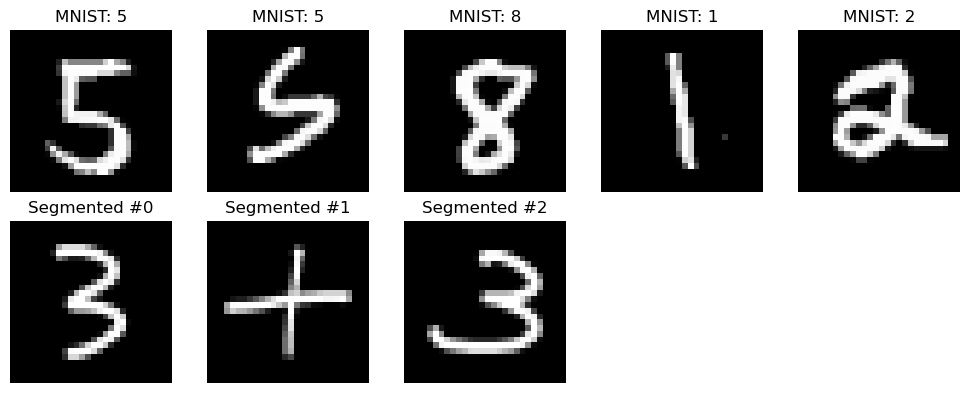

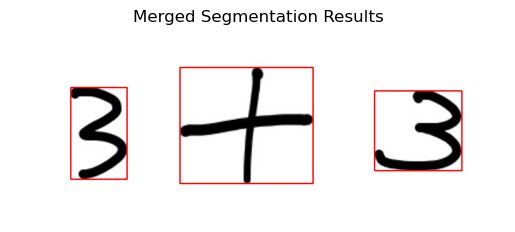

Box (127, 120, 118, 192): Classified as 3 using digit model
Box (356, 78, 279, 243): Classified as + using operator model
Box (764, 127, 183, 167): Classified as 3 using digit model
Reconstructed Expression: 3+3
Evaluation Result: 6

Processing image: expressions/5d1.png
--- MNIST Samples ---
MNIST #0 — Label: 3, Shape: (28, 28), White pixels: 170, Range: [0.00, 1.00]
MNIST #1 — Label: 2, Shape: (28, 28), White pixels: 138, Range: [0.00, 1.00]
MNIST #2 — Label: 4, Shape: (28, 28), White pixels: 150, Range: [0.00, 1.00]
MNIST #3 — Label: 2, Shape: (28, 28), White pixels: 115, Range: [0.00, 1.00]
MNIST #4 — Label: 6, Shape: (28, 28), White pixels: 124, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (272, 235, 3), Preprocessed: (28, 28), Aspect: 0.86, White pixels: 94, Range: [0.00, 1.00]
ROI #1 — Original: (201, 304, 3), Preprocessed: (28, 28), Aspect: 1.51, White pixels: 67, Range: [0.00, 1.00]
ROI #2 — Original: (166, 138, 3), Preprocessed: (28, 28), Aspect: 0.83, Whi

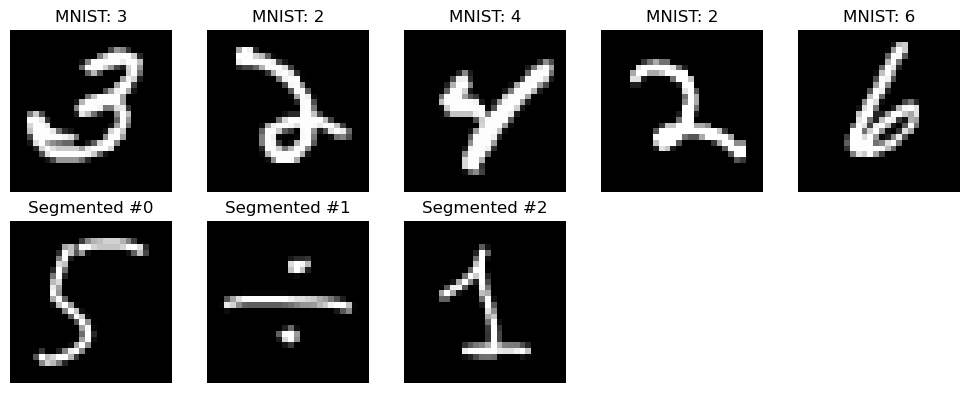

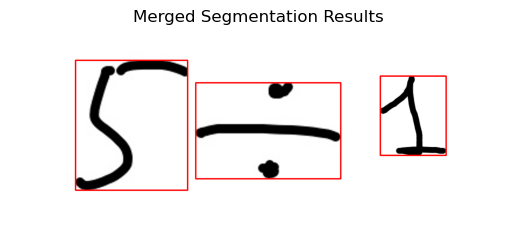

Box (137, 63, 235, 272): Classified as 5 using digit model
Box (389, 110, 304, 201): Classified as / using operator model
Box (776, 96, 138, 166): Classified as 1 using digit model
Reconstructed Expression: 5/1
Evaluation Result: 5.0

Processing image: expressions/5m8.png
--- MNIST Samples ---
MNIST #0 — Label: 1, Shape: (28, 28), White pixels: 77, Range: [0.00, 1.00]
MNIST #1 — Label: 5, Shape: (28, 28), White pixels: 187, Range: [0.00, 1.00]
MNIST #2 — Label: 1, Shape: (28, 28), White pixels: 63, Range: [0.00, 1.00]
MNIST #3 — Label: 8, Shape: (28, 28), White pixels: 168, Range: [0.00, 1.00]
MNIST #4 — Label: 1, Shape: (28, 28), White pixels: 76, Range: [0.00, 1.00]
--- Segmented Samples ---
ROI #0 — Original: (162, 196, 3), Preprocessed: (28, 28), Aspect: 1.21, White pixels: 83, Range: [0.00, 1.00]
ROI #1 — Original: (198, 218, 3), Preprocessed: (28, 28), Aspect: 1.10, White pixels: 133, Range: [0.00, 1.00]
ROI #2 — Original: (218, 154, 3), Preprocessed: (28, 28), Aspect: 0.71, Whit

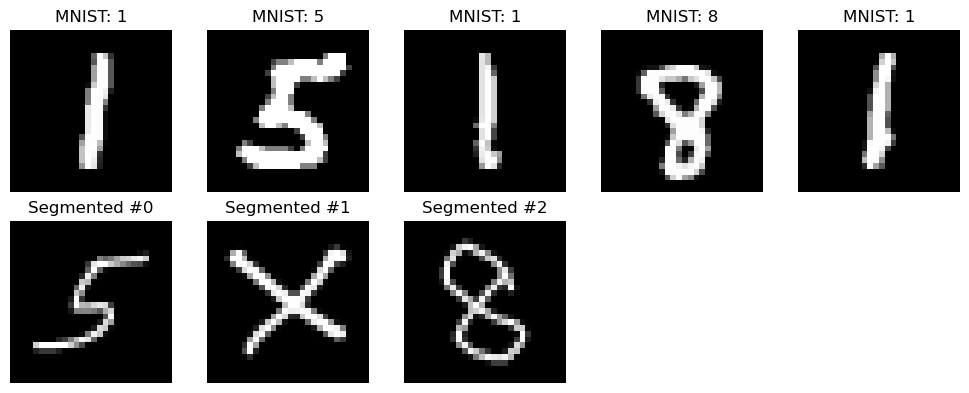

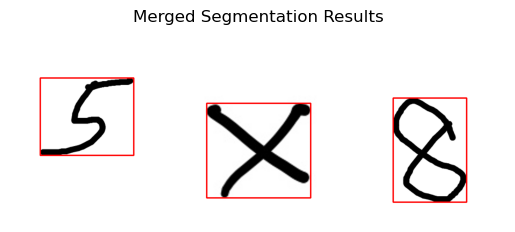

Box (63, 100, 196, 162): Classified as 5 using digit model
Box (412, 153, 218, 198): Classified as * using operator model
Box (803, 142, 154, 218): Classified as 8 using digit model
Reconstructed Expression: 5*8
Evaluation Result: 40


In [341]:
digit_model = joblib.load('digit_model.joblib')
operator_model = joblib.load('operator_model.joblib')

# load input expression images
expr_files = glob.glob(os.path.join("expressions", "*.png"))
if not expr_files:
    print("No expression images found in the 'expression' folder.")

for expr_file in expr_files:
    print(f"\nProcessing image: {expr_file}")
    expr_str = process_expression(expr_file, digit_model, operator_model, debug=True)
    print("Reconstructed Expression:", expr_str)
    
    try:
        result = safe_eval(expr_str)
        print("Evaluation Result:", result)
    except Exception as e:
        print("Evaluation Error:", e)
